In [1]:
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img
from heeps.pupil.create_pupil import create_pupil
from copy import deepcopy
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
npupil_L = update_config(**dict(read_config(), band='L'))['npupil']
npupil_N = update_config(**dict(read_config(), band='N2'))['npupil']
print('npupil_L=%s, npupil_N=%s'%(npupil_L, npupil_N))
pupil_img_size = 39.9988
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
spi_width = 0.54

npupil_L=285, npupil_N=119


In [3]:
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
r_obstr = diam_allglass_int/diam_allglass_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4
ravc_r = r_obstr/np.sqrt(1 - ravc_t)
diam_allglass_RA = ravc_r*diam_allglass_ext
print('ravc_t = %s\nravc_r = %s\ndiam_allglass_RA = %s'\
    %(np.round(ravc_t, 2), np.round(ravc_r, 2), np.round(diam_allglass_RA, 4)))

ravc_t = 0.76
ravc_r = 0.62
diam_allglass_RA = 22.9287


In [4]:
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
r_obstr = diam_fullM1_int/diam_fullM1_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4
ravc_r = r_obstr/np.sqrt(1 - ravc_t)
diam_fullM1_RA = ravc_r*diam_fullM1_ext
print('ravc_t = %s\nravc_r = %s\ndiam_fullM1_RA = %s'\
    %(np.round(ravc_t, 2), np.round(ravc_r, 2), np.round(diam_fullM1_RA, 4)))

ravc_t = 0.79
ravc_r = 0.59
diam_fullM1_RA = 22.2647


In [5]:
# optimal RA parameters wrt all-glass diameters
ravc_r_opt = 0.505
ravc_t_opt = 0.745
diam_allglass_RA_opt = ravc_r_opt*diam_allglass_ext
print('ravc_t = %s\nravc_r = %s\ndiam_allglass_RA_opt = %s'\
    %(np.round(ravc_t_opt, 3), np.round(ravc_r_opt, 3), np.round(diam_allglass_RA_opt, 4)))

ravc_t = 0.745
ravc_r = 0.505
diam_allglass_RA_opt = 18.637


# Check all-glass vs full-M1

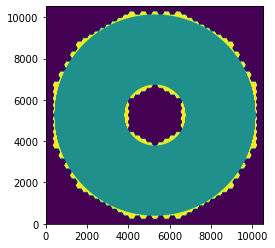

In [6]:
fullM1 = np.float32(fits.getdata('eso/mask_M1.fits'))
allglass = np.float32(fits.getdata('eso/mask_allglass.fits'))
spiders = np.float32(fits.getdata('eso/SpiderShadow.fits'))
plt.imshow(fullM1 - allglass/2, origin='lower')
nimg = fullM1.shape[0]
npupil = 1385

# Create dodecagon (ext) and hexagon (int)

In [7]:
def mask_angle(x, y, r, theta, rot):
    P = (r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta)))
    a = np.tan(np.deg2rad(theta - rot))
    b = P[1] - a*P[0]
    mask = (y > a*x + b) + (y > -a*x + b) + (y < a*x - b) + (y < -a*x - b)
    return mask
def dodecagon(r_ext, nimg):
    x, y = cart_coord(nimg)
    M1 = mask_angle(x, y, r_ext, 0 , 90)
    M2 = mask_angle(x, y, r_ext, 30, 90)
    M3 = mask_angle(x, y, r_ext, 60, 90)
    M4 = mask_angle(x, y, r_ext, 90, 90)
    return M1 + M2 + M3 + M4
def hexagon(r_int, nimg):
    x, y = cart_coord(nimg)
    M5 = mask_angle(x, y, r_int, 30, 60)
    M6 = mask_angle(x, y, r_int, 30, 120)
    return ~(M5 + M6)

In [8]:
# a bit of geometry to find the dodecagon and hexagon edges ...
seg_width = 1.45
alpha = np.arcsin(seg_width/diam_allglass_ext)
ds = seg_width*np.sin(np.pi/3)
dc = seg_width*np.cos(np.pi/3)
beta = np.arcsin(dc/diam_allglass_int)
h = np.cos(beta)*diam_allglass_int
diam_dodecagon = np.cos(alpha)*diam_allglass_ext    # 36.877
diam_hexagon = h - ds + seg_width/np.cos(np.pi/6)   # 11.608
print('diam_dodecagon = %s\ndiam_dodecagon = %s'\
    %(np.round(diam_dodecagon, 4), np.round(diam_hexagon, 4)))

diam_dodecagon = 36.8765
diam_dodecagon = 11.6081


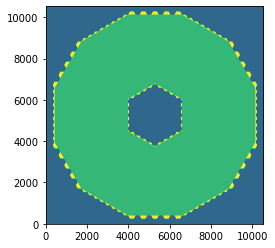

In [9]:
r_ext = diam_dodecagon/pupil_img_size
r_int = diam_hexagon/pupil_img_size
mask = dodecagon(r_ext, nimg) + hexagon(r_int, nimg)
pup = deepcopy(fullM1)
pup[mask] += 0.5
plt.imshow(pup, origin='lower');

# Create Lyot stop

In [10]:
def create_ls(d_ext, d_int, ls_dRext, ls_dRint, ls_dRspi, circ_ext=True, \
    circ_int=True):
    # create spider stop
    conf = dict(
        npupil=nimg,
        pupil_img_size=pupil_img_size, 
        diam_ext=2*pupil_img_size,  # no circular aperture
        diam_int=0,                 # no central obscuration
        seg_width=0,                # no segments
        spi_width=spi_width + ls_dRspi*diam_nominal_ext,
    )
    mask_spi = create_pupil(**conf)
    # create outer and inner stops
    r_ext = (d_ext - ls_dRext*diam_nominal_ext) / pupil_img_size
    r_int = (d_int + ls_dRint*diam_nominal_ext) / pupil_img_size
    r, t = polar_coord(nimg)
    mask_ext = (r < r_ext) if circ_ext == True else ~dodecagon(r_ext, nimg)
    mask_int = (r > r_int) if circ_int == True else ~hexagon(r_int, nimg)
    # lyot stop
    return mask_spi * mask_ext * mask_int

# L-band RAVC

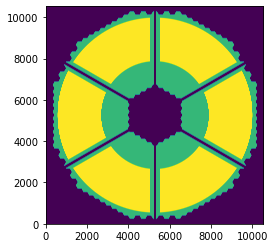

In [11]:
ls_params = (0.0291, 0.0291, 0.0317)
mask = create_ls(diam_allglass_ext, diam_allglass_RA_opt, *ls_params)
fits.writeto('ls_L_RAVC_%s_%s_%s_%s.fits'%(*ls_params, npupil_L), resize_img(mask, npupil_L), overwrite=True)
plt.imshow(fullM1*spiders + mask/2, origin='lower');

# L-band CVC

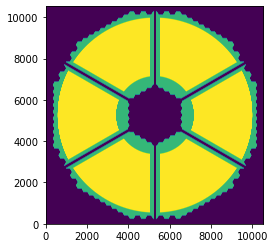

In [12]:
ls_params = (0.0291, 0.08, 0.0317)
mask = create_ls(diam_allglass_ext, diam_allglass_int, *ls_params)
fits.writeto('ls_L_CVC_%s_%s_%s_%s.fits'%(*ls_params, npupil_L), resize_img(mask, npupil_L), overwrite=True)
plt.imshow(fullM1*spiders + mask/2, origin='lower');

# N2-band CVC

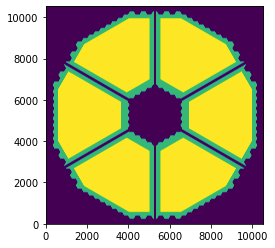

In [13]:
ls_params = (0.0356, 0.08, 0.0383)
mask = create_ls(diam_allglass_ext, diam_allglass_int, *ls_params)
fits.writeto('ls_N2_CVC_%s_%s_%s_%s_circ.fits'%(*ls_params, npupil_N), resize_img(mask, npupil_N), overwrite=True)
mask = create_ls(diam_allglass_ext, diam_allglass_int, circ_ext=False, circ_int=False, *ls_params)
fits.writeto('ls_N2_CVC_%s_%s_%s_%s.fits'%(*ls_params, npupil_N), resize_img(mask, npupil_N), overwrite=True)
plt.imshow(fullM1*spiders + mask/2, origin='lower');

# L-band CLC

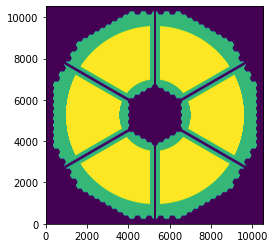

In [14]:
# values from Muskan wrt diam_nominal_ext
ls_dRext = np.round(diam_allglass_ext/diam_nominal_ext - 0.848, 4)
ls_dRint = np.round(0.34 - diam_allglass_int/diam_nominal_ext, 4)
ls_params = (ls_dRext, ls_dRint, 0.0317)
mask = create_ls(diam_allglass_ext, diam_allglass_int, *ls_params)
fits.writeto('ls_L_CLC_%s_%s_%s_%s.fits'%(*ls_params, npupil_L), resize_img(mask, npupil_L), overwrite=True)
plt.imshow(fullM1*spiders + mask/2, origin='lower');

# N2-band CLC

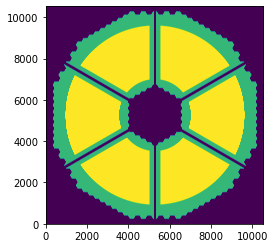

In [15]:
# values from Muskan wrt diam_nominal_ext
ls_dRext = np.round(diam_allglass_ext/diam_nominal_ext - 0.853, 4)
ls_dRint = np.round(0.342 - diam_allglass_int/diam_nominal_ext, 4)
ls_params = (ls_dRext, ls_dRint, 0.0383)
mask = create_ls(diam_allglass_ext, diam_allglass_int, *ls_params)
fits.writeto('ls_N2_CLC_%s_%s_%s_%s.fits'%(*ls_params, npupil_N), resize_img(mask, npupil_N), overwrite=True)
plt.imshow(fullM1*spiders + mask/2, origin='lower');